# 使用Google Mini Speech Commands資料集進行GMM-HMM自動語音辨識

## 載入套件

In [1]:
import numpy as np, os
import matplotlib.pyplot as plt
import pathlib

## 載入訓練資料

In [5]:
DATA_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands'
fpaths = []
labels = []
spoken = []
for f in os.listdir(DATA_PATH):
    if f == 'README.md' or f == '.DS_Store': continue
    for w in os.listdir(DATA_PATH + '/' + f):
        fpaths.append(DATA_PATH + '/' + f + '/' + w)
        labels.append(f)
        if f not in spoken:
            spoken.append(f)
print('Words spoken:', spoken)

Words spoken: ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']


## EDA

In [7]:
# 取得音檔的屬性
import wave

f=wave.open(DATA_PATH + '/down/00b01445_nohash_1.wav')
print(f'取樣頻率={f.getframerate()}, 幀數={f.getnframes()}, ' +
      f'聲道={f.getnchannels()}, 精度={f.getsampwidth()}, ' +
      f'檔案秒數={f.getnframes() / f.getframerate():.2f}')
f.close()

取樣頻率=16000, 幀數=16000, 聲道=1, 精度=2, 檔案秒數=1.00


## 合併所有檔案資料

In [8]:
from scipy.io import wavfile

# 每筆資料最多32,000幀，截長補短
data = np.zeros((len(fpaths), 32000))
maxsize = -1
for n,file in enumerate(fpaths):
    _, d = wavfile.read(file)
    data[n, :d.shape[0]] = d
    if d.shape[0] > maxsize:
        maxsize = d.shape[0]
data = data[:, :maxsize]

print('資料總筆數:', data.shape[0])
all_labels = np.zeros(data.shape[0])
for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n

# print('標記:', all_labels)

資料總筆數: 8000
標記: [0. 0. 0. ... 1. 1. 1.]


## 使用短時傅立葉轉換(Short Time Fourier Transform, STFT)萃取特徵

In [9]:
import scipy

def stft(x, fftsize=64, overlap_pct=.5):
    #Modified from http://stackoverflow.com/questions/2459295/stft-and-istft-in-python
    hop = int(fftsize * (1 - overlap_pct))
    w = scipy.signal.windows.hann(fftsize + 1)[:-1]
    raw = np.array([np.fft.rfft(w * x[i:i + fftsize]) for i in range(0, len(x) - fftsize, hop)])
    return raw[:, :(fftsize // 2)]

## 顯示第一筆波形及特徵萃取

(498, 32)


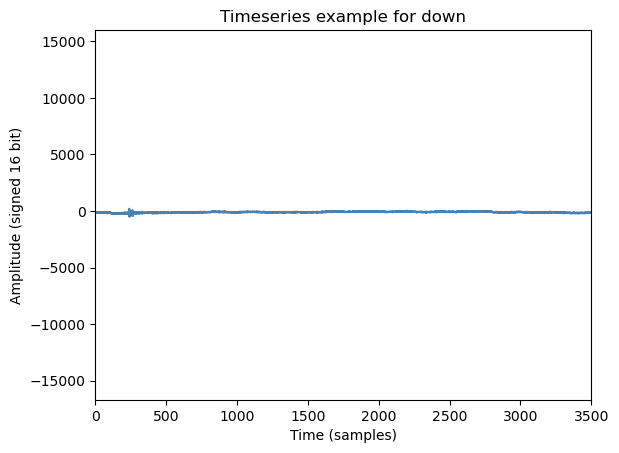

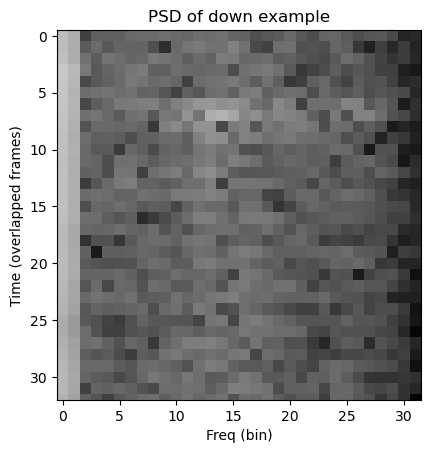

In [10]:
import matplotlib.pyplot as plt

plt.plot(data[0, :], color='steelblue')
plt.title('Timeseries example for %s'%labels[0])
plt.xlim(0, 3500)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (signed 16 bit)')
plt.figure()

# + 1 to avoid log of 0
log_freq = 20 * np.log(np.abs(stft(data[0, :])) + 1)
print(log_freq.shape)
plt.imshow(log_freq, cmap='gray', interpolation=None)
plt.xlabel('Freq (bin)')
plt.ylabel('Time (overlapped frames)')
plt.ylim(log_freq.shape[1])
plt.title('PSD of %s example'%labels[0])
plt.show()

## 定義函數以偵測每一個SFFT的峰值

In [11]:
# Peak detection using the technique described here: 
# http://kkjkok.blogspot.com/2013/12/dsp-snippets_9.html
from numpy.lib.stride_tricks import as_strided

def peakfind(x, n_peaks, l_size=3, r_size=3, c_size=3, f=np.mean):
    win_size = l_size + r_size + c_size
    shape = x.shape[:-1] + (x.shape[-1] - win_size + 1, win_size)
    strides = x.strides + (x.strides[-1],)
    xs = as_strided(x, shape=shape, strides=strides)
    def is_peak(x):
        centered = (np.argmax(x) == l_size + int(c_size/2))
        l = x[:l_size]
        c = x[l_size:l_size + c_size]
        r = x[-r_size:]
        passes = np.max(c) > np.max([f(l), f(r)])
        if centered and passes:
            return np.max(c)
        else:
            return -1
    r = np.apply_along_axis(is_peak, 1, xs)
    top = np.argsort(r, None)[::-1]
    heights = r[top[:n_peaks]]
    #Add l_size and half - 1 of center size to get to actual peak location
    top[top > -1] = top[top > -1] + l_size + int(c_size / 2.)
    return heights, top[:n_peaks]

## 顯示峰值

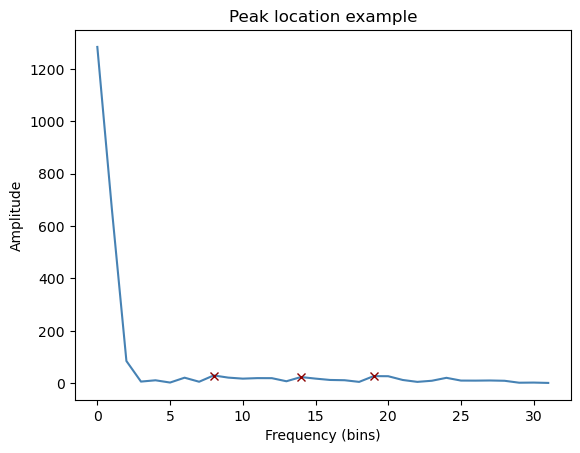

In [12]:
plot_data = np.abs(stft(data[20, :]))[15, :]
values, locs = peakfind(plot_data, n_peaks=6)
fp = locs[values > -1]
fv = values[values > -1]
plt.plot(plot_data, color='steelblue')
plt.plot(fp, fv, 'x', color='darkred')
plt.title('Peak location example')
plt.xlabel('Frequency (bins)')
plt.ylabel('Amplitude')
plt.show()

## 偵測所有資料的峰值

In [13]:
# This processing (top freq peaks) only works for single speaker case
all_obs = []
for i in range(data.shape[0]):
    d = np.abs(stft(data[i, :]))
    n_dim = 6
    obs = np.zeros((n_dim, d.shape[0]))
    for r in range(d.shape[0]):
        _, t = peakfind(d[r, :], n_peaks=n_dim)
        obs[:, r] = t.copy()
    if i % 200 == 0:
        print("Processed obs %s" % i)
    all_obs.append(obs)

all_obs = np.atleast_3d(all_obs)

Processed obs 0
Processed obs 10
Processed obs 20
Processed obs 30
Processed obs 40
Processed obs 50
Processed obs 60
Processed obs 70
Processed obs 80
Processed obs 90
Processed obs 100
Processed obs 110
Processed obs 120
Processed obs 130
Processed obs 140
Processed obs 150
Processed obs 160
Processed obs 170
Processed obs 180
Processed obs 190
Processed obs 200
Processed obs 210
Processed obs 220
Processed obs 230
Processed obs 240
Processed obs 250
Processed obs 260
Processed obs 270
Processed obs 280
Processed obs 290
Processed obs 300
Processed obs 310
Processed obs 320
Processed obs 330
Processed obs 340
Processed obs 350
Processed obs 360
Processed obs 370
Processed obs 380
Processed obs 390
Processed obs 400
Processed obs 410
Processed obs 420
Processed obs 430
Processed obs 440
Processed obs 450
Processed obs 460
Processed obs 470
Processed obs 480
Processed obs 490
Processed obs 500
Processed obs 510
Processed obs 520
Processed obs 530
Processed obs 540
Processed obs 550
Pro

## GMM-HMM
### 程式來源：[kastnerkyle/gmmhmm.py](https://gist.github.com/kastnerkyle/75483d51641a0c03bf7c)

In [15]:
import scipy.stats as st
import numpy as np

class gmmhmm:
    def __init__(self, n_states):
        self.n_states = n_states
        self.random_state = np.random.RandomState(0)

        #Normalize random initial state
        self.prior = self._normalize(self.random_state.rand(self.n_states, 1))
        self.A = self._stochasticize(self.random_state.rand(self.n_states, self.n_states))

        self.mu = None
        self.covs = None
        self.n_dims = None

    def _forward(self, B):
        log_likelihood = 0.
        T = B.shape[1]
        alpha = np.zeros(B.shape)
        for t in range(T):
            if t == 0:
                alpha[:, t] = B[:, t] * self.prior.ravel()
            else:
                alpha[:, t] = B[:, t] * np.dot(self.A.T, alpha[:, t - 1])

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood = log_likelihood + np.log(alpha_sum)
        return log_likelihood, alpha

    def _backward(self, B):
        T = B.shape[1]
        beta = np.zeros(B.shape);

        beta[:, -1] = np.ones(B.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.A, (B[:, t + 1] * beta[:, t + 1]))
            beta[:, t] /= np.sum(beta[:, t])
        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.n_states, obs.shape[1]))
        for s in range(self.n_states):
            #Needs scipy 0.14
            np.random.seed(self.random_state.randint(1))
            B[s, :] = st.multivariate_normal.pdf(
                obs.T, mean=self.mu[:, s].T, cov=self.covs[:, :, s].T)
            #This function can (and will!) return values >> 1
            #See the discussion here for the equivalent matlab function
            #https://groups.google.com/forum/#!topic/comp.soft-sys.matlab/YksWK0T74Ak
            #Key line: "Probabilities have to be less than 1,
            #Densities can be anything, even infinite (at individual points)."
            #This is evaluating the density at individual points...
        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        #Using this _em_init function allows for less required constructor args
        if self.n_dims is None:
            self.n_dims = obs.shape[0]
        if self.mu is None:
            subset = self.random_state.choice(np.arange(self.n_dims), 
                                              size=self.n_states, replace=False)
            self.mu = obs[:, subset]
        if self.covs is None:
            self.covs = np.zeros((self.n_dims, self.n_dims, self.n_states))
            self.covs += np.diag(np.diag(np.cov(obs)))[:, :, None]
        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        B = self._state_likelihood(obs)
        T = obs.shape[1]

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.n_states, self.n_states))
        gamma = np.zeros((self.n_states, T))

        for t in range(T - 1):
            partial_sum = self.A * np.dot(alpha[:, t], (beta[:, t] * B[:, t + 1]).T)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)

        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = gamma[:, 0]
        expected_A = self._stochasticize(xi_sum)

        expected_mu = np.zeros((self.n_dims, self.n_states))
        expected_covs = np.zeros((self.n_dims, self.n_dims, self.n_states))

        gamma_state_sum = np.sum(gamma, axis=1)
        #Set zeros to 1 before dividing
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        for s in range(self.n_states):
            gamma_obs = obs * gamma[s, :]
            expected_mu[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]
            partial_covs = np.dot(gamma_obs, obs.T) / gamma_state_sum[s] - np.dot(expected_mu[:, s], expected_mu[:, s].T)
            #Symmetrize
            partial_covs = np.triu(partial_covs) + np.triu(partial_covs).T - np.diag(partial_covs)

        #Ensure positive semidefinite by adding diagonal loading
        expected_covs += .01 * np.eye(self.n_dims)[:, :, None]

        self.prior = expected_prior
        self.mu = expected_mu
        self.covs = expected_covs
        self.A = expected_A
        return log_likelihood

    def fit(self, obs, n_iter=15):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            for i in range(n_iter):
                self._em_init(obs)
                log_likelihood = self._em_step(obs)
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            for n in range(count):
                for i in range(n_iter):
                    self._em_init(obs[n, :, :])
                    log_likelihood = self._em_step(obs[n, :, :])
        return self

    def transform(self, obs):
        #Support for 2D and 3D arrays
        #2D should be n_features, n_dims
        #3D should be n_examples, n_features, n_dims
        #For example, with 6 features per speech segment, 105 different words
        #this array should be size
        #(105, 6, X) where X is the number of frames with features extracted
        #For a single example file, the array should be size (6, X)
        if len(obs.shape) == 2:
            B = self._state_likelihood(obs)
            log_likelihood, _ = self._forward(B)
            return log_likelihood
        elif len(obs.shape) == 3:
            count = obs.shape[0]
            out = np.zeros((count,))
            for n in range(count):
                B = self._state_likelihood(obs[n, :, :])
                log_likelihood, _ = self._forward(B)
                out[n] = log_likelihood
            return out

## 資料分割

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(test_size=0.2, random_state=0)

for n,i in enumerate(all_obs):
    all_obs[n] /= all_obs[n].sum(axis=0)

for train_index, test_index in sss.split(X=all_obs, y=all_labels):
    X_train, X_test = all_obs[train_index, ...], all_obs[test_index, ...]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

Size of training matrix: (6400, 6, 498)
Size of testing matrix: (1600, 6, 498)


## 模型訓練

In [16]:
ys = set(all_labels)
ms = [gmmhmm(6) for y in ys]
_ = [m.fit(X_train[y_train == y, :, :]) for m, y in zip(ms, ys)]
ps = [m.transform(X_test) for m in ms]
res = np.vstack(ps)
predicted_labels = np.argmax(res, axis=0)
missed = (predicted_labels != y_test)
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))

Test accuracy: 12.44 percent


## 顯示混淆矩陣

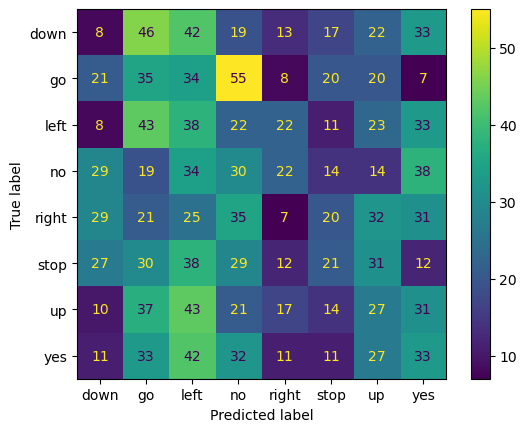

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=spoken)
disp.plot()
plt.show()